# Analysis Eikon

Load some example data from the fixtures.
Because the data has a header row we remove it.
We then tanspose the data so that we have a column for each channel.
We remove the first column because it is just a counter and the last 2 because they are gain and other information.

In [1]:
import os
import pathlib
import numpy as np
import lib.add_lib_path
import lib.helpers as h



__file__ = os.path.abspath("__file__")
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '../lib')))
# fixturePath = pathlib.Path(__file__).parent.joinpath('fixtures')
# csvPath = pathlib.Path(fixturePath).joinpath('colorSensor.csv')
# csvData = h.loadCsvDataAsInt(csvPath)
# csvData.pop(0)
# data = np.array(csvData).T.tolist()

# data = data[1:13]

# print(f'Loaded {len(data)} columns of data.')


In [2]:
import lib.api_auth as auth
import lib.graphql_queries as qry

api = auth.getApiClient()
consumableId = '5fce000a-acc2-46e4-ad54-8d3bd27905a2'
where = {'id':{'_eq': consumableId}}
response = api.execute(query=qry.consumableWhere,variables={'where':where})

# print(response)

# print(response)
rawData = response['data']['consumable'][0]['experiments'][0]['experimentResult']['pcrData']['sensor']
data = np.array(rawData).T.tolist()
# print(data)
# x = np.divide(data[6],data[7])

import matplotlib.pyplot as plt
# print(data)


TypeError: 'NoneType' object is not subscriptable

Load the appropriate configuration for the consumable:

In [ ]:
from lib.consumable_config import getConfigMap

consumableName = 'lambda'
configuration = getConfigMap(consumableName)

print(f'The configuration for {configuration["name"]} has been loaded')


The configuration for lambda has been loaded


Load the pcr analysis class. Initialize with configuration and then callPCR with data.

## PCR Analysis

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import pcr.add_pcr_path
from pcr import pcr

# clear_output(wait=True)

pcrAnalysis = pcr.PCRAnalysis(configuration)
pcrAnalysis.callPCR(data)

calls = pcrAnalysis.results['pcrCalls']
cqs = pcrAnalysis.results['cqs']

positiveCalls = []
negativeCalls = []
for i in range(9):
    if calls[i] == 1:
        positiveCalls.append(i)
    elif calls[i] == -1:
        negativeCalls.append(i)

print('Postive Calls', [h.getNameFromIndex(i) for i in positiveCalls])
print('Cqs respectively', [cqs[i] for i in positiveCalls])
print('Negative Calls', [h.getNameFromIndex(i) for i in negativeCalls])
    

Postive Calls ['415nm', '445nm', '480nm', '515nm', '555nm', '630nm', '680nm', 'clear']
Cqs respectively [12.16, 11.36, 25.0, 25.12, 24.36, 12.66, 12.21, 25.43]
Negative Calls ['590nm']


### Print the positive calls:

dict_keys(['rawData', 'current', 'background', 'backgroundSubtracted', 'smoothed', 'smoothedLowerBounds', 'smoothedUpperBounds', 'noise', 'noiseMagnitude', 'meanShiftNormalized', 'tilted', 'detrended', 'firstDerivative', 'cps', 'curveDepth', 'curveRiseRatio', 'curveToNoiseRatio', 'cqs', 'intracycleCps', 'scoresFluorChangePos', 'scoresFluorChangeNeg', 'pcrCalls'])
41.36
2.4
40
276


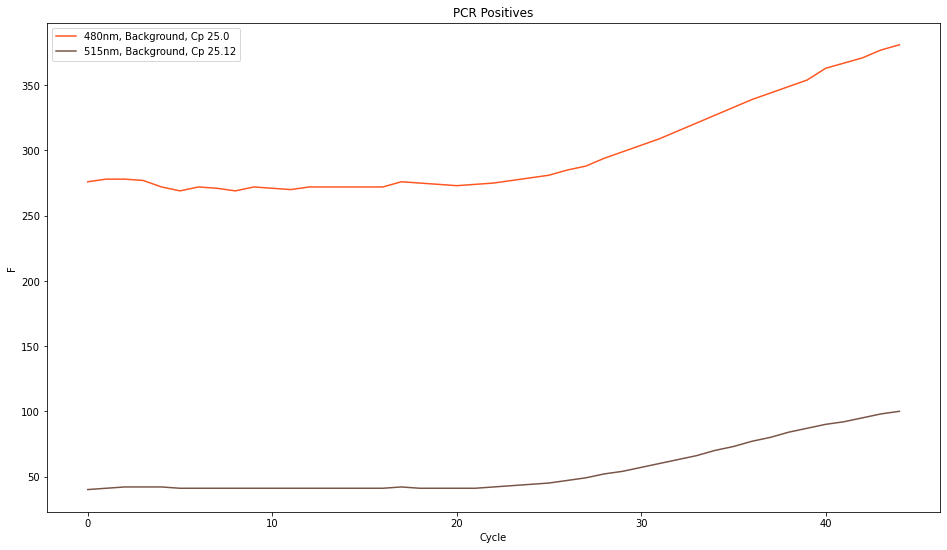

In [ ]:

plt.figure(figsize=(16, 9))
for i in [2,3]:
    c = calls[i]
    cp = pcrAnalysis.results['cqs'][i]
    plt.plot(
        pcrAnalysis.results['rawData'][i], color=h.getColor(i+12), label=f'{h.getNameFromIndex(i)}, Background, Cp {cp}')
    
    
plt.title("PCR Positives")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()
print(pcrAnalysis.results.keys())
last = pcrAnalysis.results['rawData'][3][-1]
first = np.average(pcrAnalysis.results['rawData'][3][:int(pcrAnalysis.results['cqs'][3])])
print(first)
print(np.round(last/first,1))
print(pcrAnalysis.results['rawData'][3][0])
print(pcrAnalysis.results['rawData'][2][0])



pass

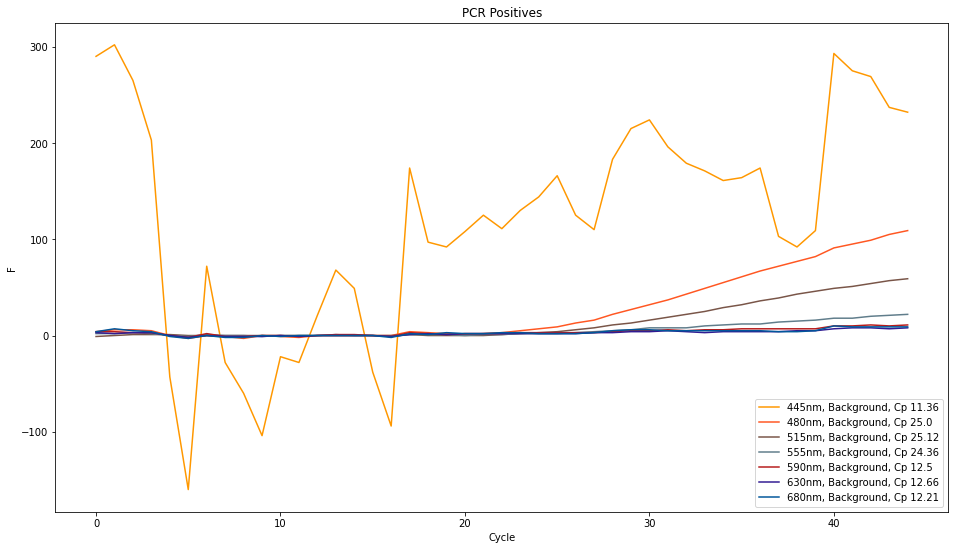

In [ ]:
plt.figure(figsize=(16, 9))
for i in [h.nm445, h.nm480, h.nm515, h.nm555, h.nm590, h.nm630, h.nm680]:
    c = calls[i]
    cp = pcrAnalysis.results['cqs'][i]
    plt.plot(
        pcrAnalysis.results['backgroundSubtracted'][i], color=h.getColor(i+12), label=f'{h.getNameFromIndex(i)}, Background, Cp {cp}')
    
import pandas as pd
count = 0
stuff = {}
for i in ['415','445','480','515','555','590','630','680']:
    stuff[i] = pcrAnalysis.results['backgroundSubtracted'][count]
    count += 1
dF = pd.DataFrame(stuff)
dF.to_csv('test_back.csv')



plt.title("PCR Positives")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()

pass

In [ ]:
msn = pcrAnalysis.results['meanShiftNormalized']

sum = np.sum(np.array(msn)[[2,3,6],:], axis=0)

plt.plot(
        sum, color=h.getColor(i), label=f'Sum of 480,515,555')
    
plt.title("PCR")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()



TypeError: not all arguments converted during string formatting

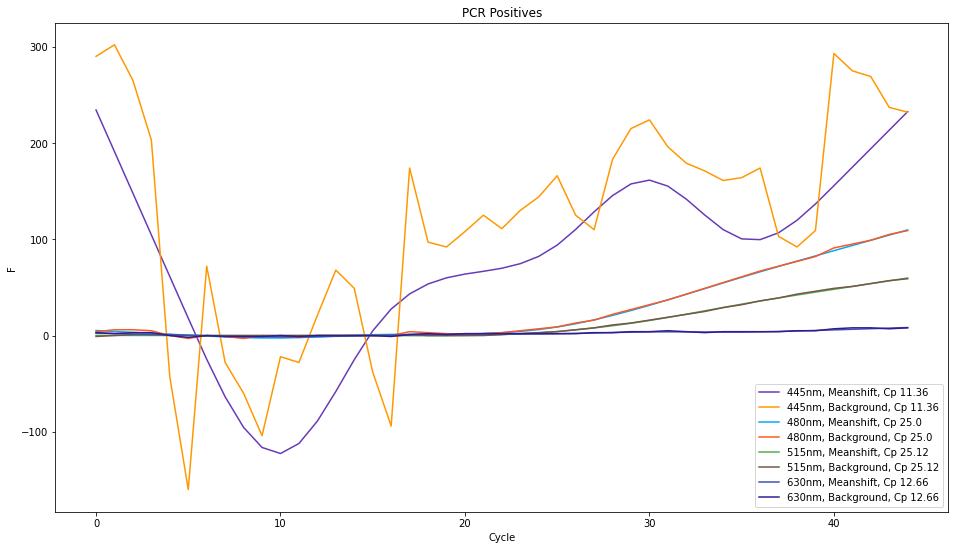

In [ ]:
plt.figure(figsize=(16, 9))
for i in [1,2,3,6]:
    c = calls[i]
    cp = pcrAnalysis.results['cqs'][i]
    plt.plot(
        pcrAnalysis.results['meanShiftNormalized'][i], color=h.getColor(i), label=f'{h.getNameFromIndex(i)}, Meanshift, Cp {cp}')
    plt.plot(
        pcrAnalysis.results['backgroundSubtracted'][i], color=h.getColor(i+12), label=f'{h.getNameFromIndex(i)}, Background, Cp {cp}')
    
plt.title("PCR Positives")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()

pass

A convient way of looking at a PCR curve is the difference from a linear fit. This difference places the CP at the most negative point. The "depth" of this curve tells us about how steep and clear the rise is out of background.

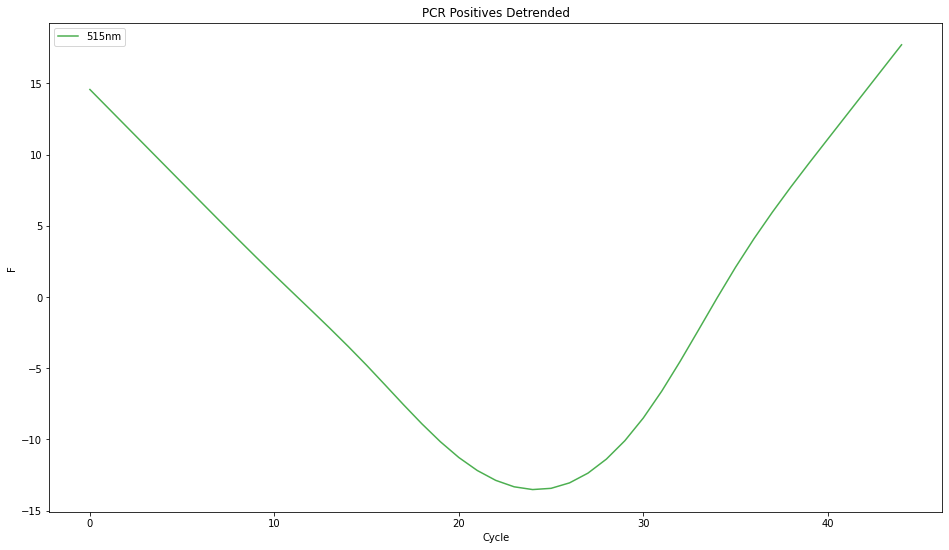

In [ ]:
plt.figure(figsize=(16, 9))
for i in [3]:
    c = calls[i]
    
    plt.plot(
        pcrAnalysis.results['tilted'][i], color=h.getColor(i), label=f'{h.getNameFromIndex(i)}')
    
plt.title("PCR Positives Detrended")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()

pass

### Print the negative calls:

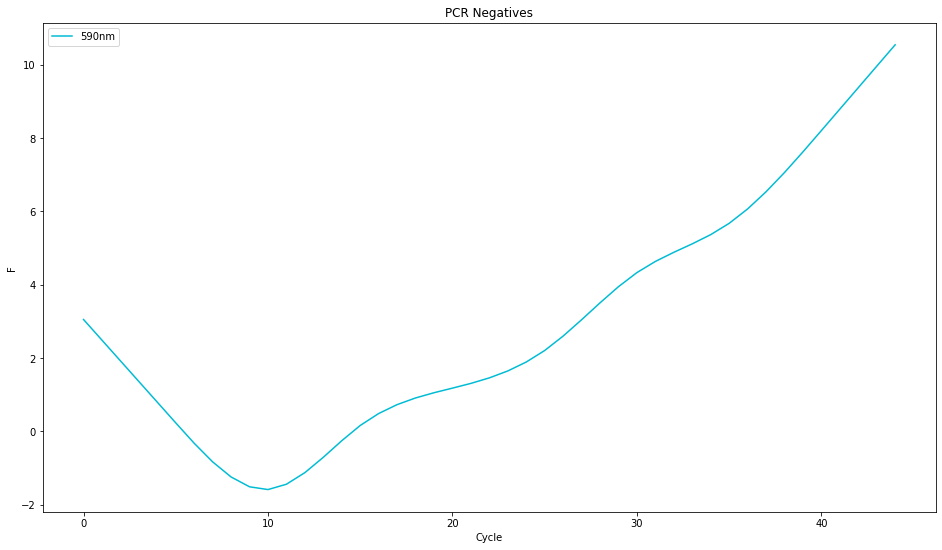

In [ ]:
plt.figure(figsize=(16, 9))
for i in negativeCalls:
    c = calls[i]
    
    plt.plot(
        pcrAnalysis.results['meanShiftNormalized'][i], color=h.getColor(i), label=f'{h.getNameFromIndex(i)}')
    
plt.title("PCR Negatives")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()

pass


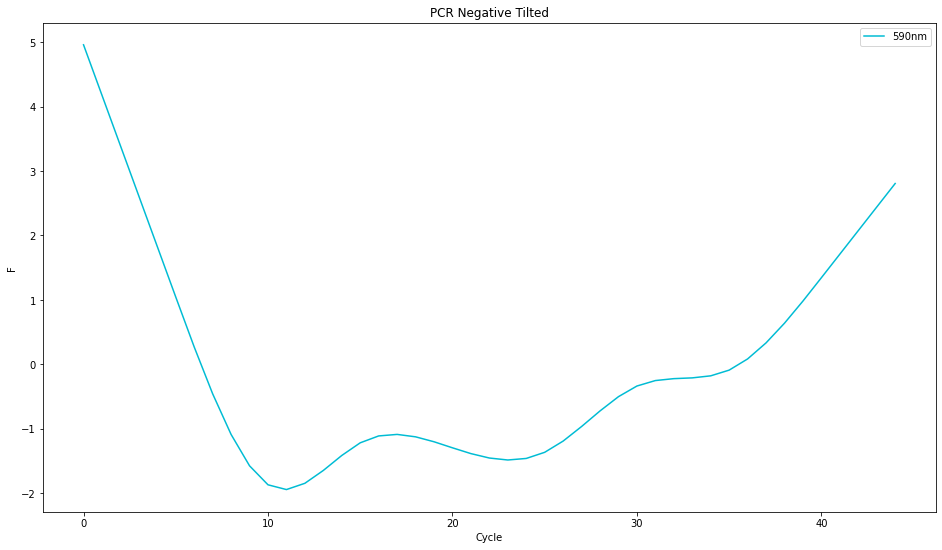

In [ ]:
plt.figure(figsize=(16, 9))
for i in negativeCalls:
    c = calls[i]
    
    plt.plot(
        pcrAnalysis.results['tilted'][i], color=h.getColor(i), label=f'{h.getNameFromIndex(i)}')
    
plt.title("PCR Negative Tilted")
plt.ylabel("F")
plt.xlabel("Cycle")
plt.legend()

pass

## Melt Analysis

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '../melt')))

# fixturePath = pathlib.Path(__file__).parent.joinpath('fixtures')
# csvPath = pathlib.Path(fixturePath).joinpath('meltColorSensor.csv')
# csvData = h.loadCsvDataAsFloat(csvPath)
# csvData.pop(0)
# mData = np.array(csvData).T.tolist()

# mData = mData[1:13]

# csvPath = pathlib.Path(fixturePath).joinpath('meltTemperatures.csv')
# csvData = h.loadCsvDataAsFloat(csvPath)
# csvData.pop(0)

# tData = np.array(csvData).T.tolist()
# tData = tData[1:][0]

# print(f'Loaded {len(mData)} columns of {len(tData)} points.')


In [4]:
melt = response['data']['consumable'][0]['experiments'][0]['experimentResult']['meltData']['sensor']

mData = np.array(melt).T.tolist()
tData = response['data']['consumable'][0]['experiments'][0]['experimentResult']['meltData']['temperature']
mData = [pd.read_csv('maddisonRun.csv')['515'].tolist(),pd.read_csv('maddisonRun.csv')['515'].tolist(),pd.read_csv('maddisonRun.csv')['515'].tolist(),pd.read_csv('maddisonRun.csv')['515'].tolist(),]
tData = pd.read_csv('maddisonRun.csv')['Temp C'].tolist()
# print(type(mData))
# print(mData)
# tData = tData[1:]

# print(tData)
pass

TypeError: 'NoneType' object is not subscriptable

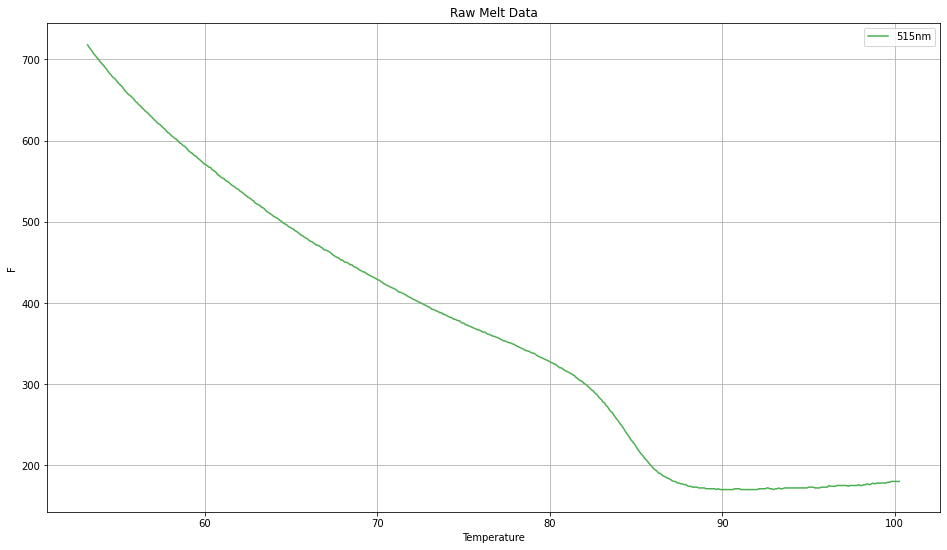

In [ ]:
plt.figure(figsize=(16, 9))
for i in [3]:
    plt.plot(
        tData,
        mData[i],  
        color=h.getColor(i), label=f'{h.getNameFromIndex(i)}')
    
plt.title("Raw Melt Data")
plt.ylabel("F")
plt.xlabel("Temperature")
plt.legend()
plt.grid()

pass

In [ ]:
from melt.melt import MeltAnalysis

print(len(tData), len(mData))
meltAnalysis = MeltAnalysis(configuration)
meltAnalysis.callMelt(tData, mData)


488 4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


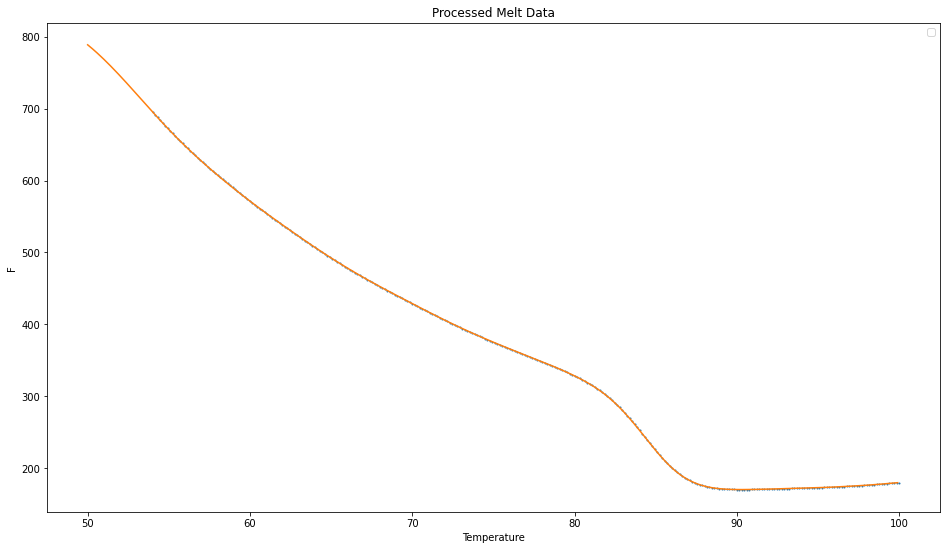

In [ ]:
from scipy.interpolate import CubicSpline



plt.figure(figsize=(16, 9))
for i in [3]:
    plt.plot(
        meltAnalysis.results['smoothedT'],  
        meltAnalysis.results['smoothed'][i],'.',markersize=2)
    # plt.plot(
    #     meltAnalysis.results['temperatures'],  
    #     meltAnalysis.results['rawData'][i],
    #     'o',
    #     alpha=0.3,
    #     color=h.getColor(i+17), label=f'{h.getNameFromIndex(i)} Raw')
    
    # plt.plot(
    #     meltAnalysis.results['smoothedT'],  
    #     meltAnalysis.results['leadExp'][i],
    #     '--',
    #     alpha=0.4,
    #     color=h.getColor(i+17+17), label=f'{h.getNameFromIndex(i)} Exponential')


plt.title("Processed Melt Data")
plt.ylabel("F")
plt.xlabel("Temperature")
plt.legend()

x = CubicSpline(meltAnalysis.results['smoothedT'],meltAnalysis.results['smoothed'][3])
# print(x)
y = np.arange(50,100,.1)
plt.plot(y,x(y))


pass

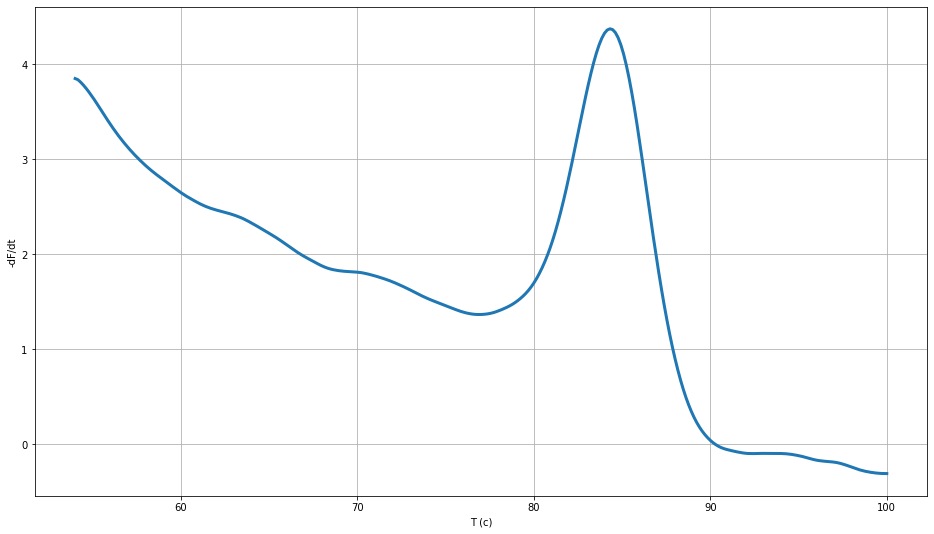

In [ ]:
plt.figure(figsize=(16, 9))
import pandas as pd
for i in [3]:
    plt.plot(
        meltAnalysis.results['smoothedT'],  
        meltAnalysis.results['smoothDerivatives'][i]
        ,lw=3, label=f'{h.getNameFromIndex(i)} Smoothed')

chan = ['415','445','480','515']
testdown = {'T':meltAnalysis.results['smoothedT']}
count = 0
for i in chan:
    testdown[i] = meltAnalysis.results['smoothDerivatives'][count]
    count += 1
dF = pd.DataFrame(testdown)
dF.to_csv('test_deriv.csv')
# print(meltAnalysis.results['smoothDerivatives'])

# plt.title("Smoothed Melt Data")
plt.ylabel("-dF/dt")
plt.xlabel("T (c)")
# plt.legend()
plt.grid()

pass

IndexError: list index out of range

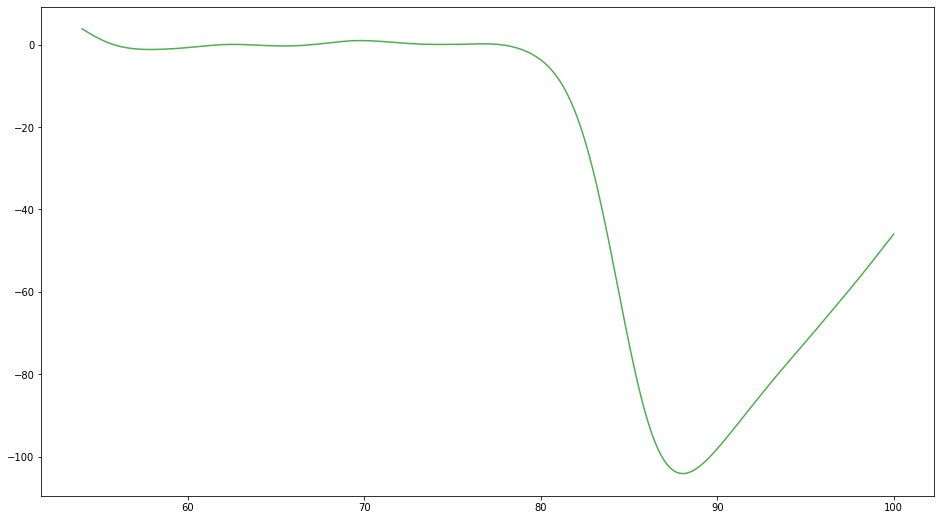

In [ ]:
plt.figure(figsize=(16, 9))
for i in [3,6,7]:
    plt.plot(
        meltAnalysis.results['smoothedT'],  
        meltAnalysis.results['expDiff'][i],
        color=h.getColor(i), label=f'{h.getNameFromIndex(i)} Exponential Normalized')
    


plt.title("Exponential Difference Melt Data")
plt.ylabel("F")
plt.xlabel("Temperature")
plt.legend()

pass

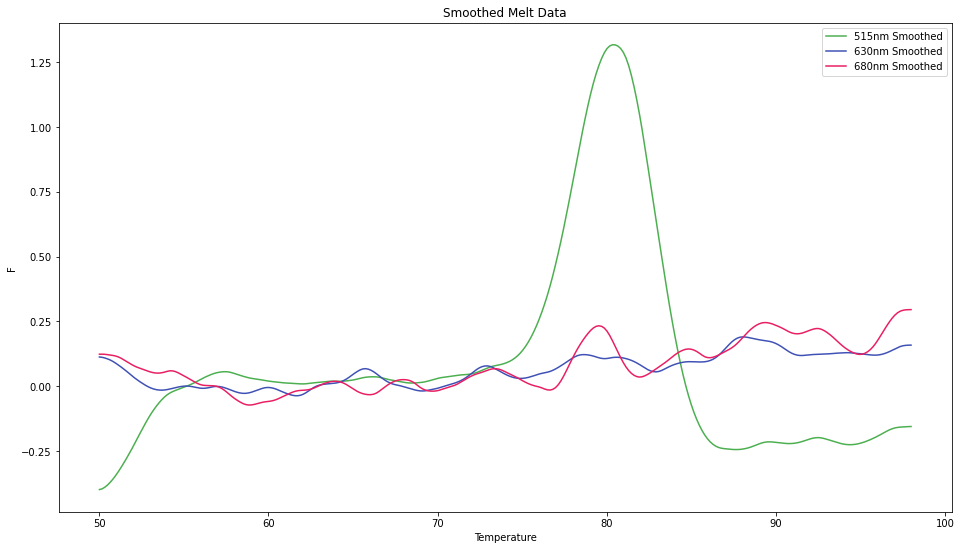

In [ ]:
plt.figure(figsize=(16, 9))
for i in [3,6,7]:
    plt.plot(
        meltAnalysis.results['smoothedT'],  
        meltAnalysis.results['derivatives'][i],
        color=h.getColor(i), label=f'{h.getNameFromIndex(i)} Smoothed')
    


plt.title("Smoothed Melt Data")
plt.ylabel("F")
plt.xlabel("Temperature")
plt.legend()


pass

In [ ]:
plt.figure(figsize=(16, 9))


mavBlue = [0.00195, 0.0632, 0.849, 0.332, 0.0716, 0.0218, 0.00493, 0.000901]

channels = np.array([0,1,2,3,4])
row = np.array([9.9, 20.8, 13.1, 13.9, 15.2])
background = np.array([10.0, 20.0, 10.0, 10.0, 10.0])
dye1 = np.array([0.0, 0.1, 0.2, 0.3, 0.4])

def bgLineExp(x, m, b):
    return np.add(np.multiply(background, m), b)

def bgScalarExp(x, b):
    return np.add(background, b)


# def dye1Exp(x, m, b):
#     return np.add(np.multiply(dye1, m), b)

def dye1ScalarExp(x, m, b):
    return np.multiply(np.add(dye1, b), m)

def dye1MultipleExp(x, m, b):
    return np.multiply(dye1, m)

# params, cv = scipy.optimize.curve_fit(bgLineExp, channels, row, (20, 10))
# m, b = params
# backgroundA = monoExp(row, m, b)
# params, cv = scipy.optimize.curve_fit(bgScalarExp, channels, row, (20))
# b = params
# backgroundA = bgScalarExp(row, b)
# backgroundSubtracted = np.subtract(row, backgroundA)

backgroundSubtracted = np.subtract(row, background)
# print('moved background ', b)

def dye1Exp(x, m, b):
    # np.multiply(backgroundSubtracted, dye1)
    # return np.subtract(backgroundSubtracted, np.add(np.multiply(x, m), b))
    return np.add(np.multiply(x, m), b)
    # return np.add(np.multiply(backgroundSubtracted, dye1), moved)
    # return np.add(np.multiply(dye1, m), b)

params, cv = scipy.optimize.curve_fit(dye1Exp, channels, backgroundSubtracted, (20, 10), bounds=([0, -65000], [65000, 65000]))
# params, cv = scipy.optimize.curve_fit(dye1MultipleExp, cycles, backgroundSubtracted, (20, 10))
m, b = params
print('the dyeA fit ', m, b)
dyeB = np.add(np.multiply(dye1, m), b)
dyeBSubtracted = np.subtract(backgroundSubtracted, dyeB)
dyeASubtracted = np.subtract(backgroundSubtracted, dyeBSubtracted)


def someExp(channels, m, b):
    return np.multiply(np.add(np.multiply(dye1, m), b), dye1)

# want 10 and 0 out.
params, cv = scipy.optimize.curve_fit(someExp, channels, np.multiply(backgroundSubtracted, dye1), (20, 10), bounds=([0, -65000], [65000, 65000]))
# params, cv = scipy.optimize.curve_fit(dye1MultipleExp, cycles, backgroundSubtracted, (20, 10))
m, b = params
print('want 10 and 0', m, b)

dye1Signal = np.add(np.multiply(dye1, m), b)
dye2Signal = np.subtract(backgroundSubtracted, dye1Signal)


plt.plot(channels, backgroundSubtracted, 'o--', color=helpers.getColor(0), label='background subtracted')
# plt.plot(channels, dye1, color=helpers.getColor(9), label='dye1 pattern')
plt.plot(channels, dye1Signal,'o--', color=helpers.getColor(9), label='dye1 signal')
plt.plot(channels, dye2Signal, 'o--',color=helpers.getColor(32), label='dye2 signal')
# plt.plot(channels, np.multiply(backgroundSubtracted, dye1), color=helpers.getColor(45), label='background * dye1 pattern')
# plt.plot(channels, someExp(channels, 9.9, 0.01), color=helpers.getColor(8), label='minimize exp')
# plt.plot(channels, np.multiply(someExp(channels, 9.9, 0.01), dye1), color=helpers.getColor(0), label='raw signal')
# plt.plot(channels, np.multiply(dye1,2), color=helpers.getColor(0), label='raw signal')

# plt.plot(channels, row, color=helpers.getColor(0), label='raw signal')
# plt.plot(cycles,
#         background,  
#         color=helpers.getColor(1), label=f'background')
# plt.plot(channels,
#         backgroundA,  
#         color=helpers.getColor(2), label=f'backgroundA')
# plt.plot(channels,
#     backgroundSubtracted,color=helpers.getColor(3), label=f'dyeB and dyeA signal')
# plt.plot(channels,
#     dyeB,color=helpers.getColor(4), label=f'dyeB')
# plt.plot(channels,
#     dyeBSubtracted,color=helpers.getColor(53), label=f'dyeB signal')
# plt.plot(cycles,
#     dyeASubtracted,color=helpers.getColor(6), label=f'dyeA Signal')


plt.legend()

print(dyeBSubtracted[1])

print('Total dye1 signal', np.sum(dye1Signal))
print('Total dye2 signal', np.sum(dye2Signal))




NameError: name 'scipy' is not defined

<Figure size 1152x648 with 0 Axes>

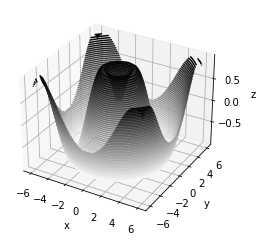

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')


# syntax for 3-D projection

def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# plotting
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');